In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as spstat
import emp_functions as empf

plt.rcParams.update({"font.size": 20, "figure.figsize": (10, 8), "xtick.direction": "in", "ytick.direction": "in"})
#np.set_printoptions(threshold=sys.maxsize)

## INSPECTING THE RAW DATA FILE

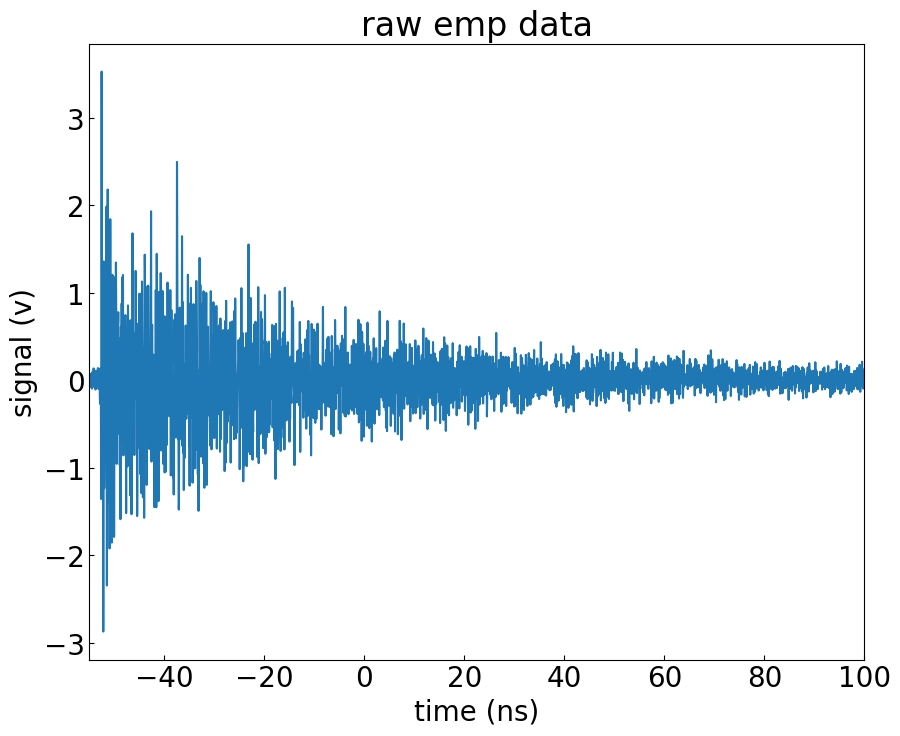

In [2]:
raw_file = "data\\s28.csv"
corrected_file = "data\\corrected_sig_waveform_Cikhardt23.csv"
trigger_time = -55 #ns. The time where the signal is defined to start.

raw_time, _, _, raw_emp, _ = np.genfromtxt(raw_file, delimiter= ",").T
raw_time *= 1e9 #convert to ns
trigger_index = next(n for n, t in enumerate(raw_time) if trigger_time <= t)
raw_time, raw_emp, raw_noise = raw_time[trigger_index:], raw_emp[trigger_index:], raw_emp[:trigger_index]

fig, axs = plt.subplots()

axs.plot(raw_time, raw_emp)
axs.set(xlim = (-55, 100), title= "raw emp data", xlabel= "time (ns)", ylabel= "signal (v)")
plt.show()

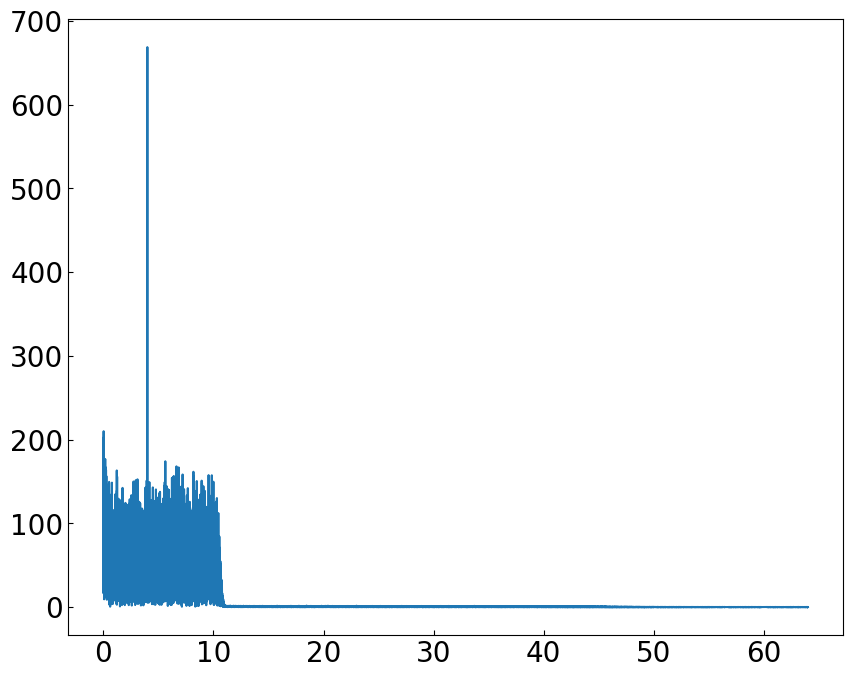

In [25]:
freqs = np.fft.rfftfreq(len(raw_noise), raw_dt) # dt was in ns so freqs should be in GHz

plt.plot(freqs[1:], np.abs(np.fft.rfft(raw_noise)[1:]))
plt.show()

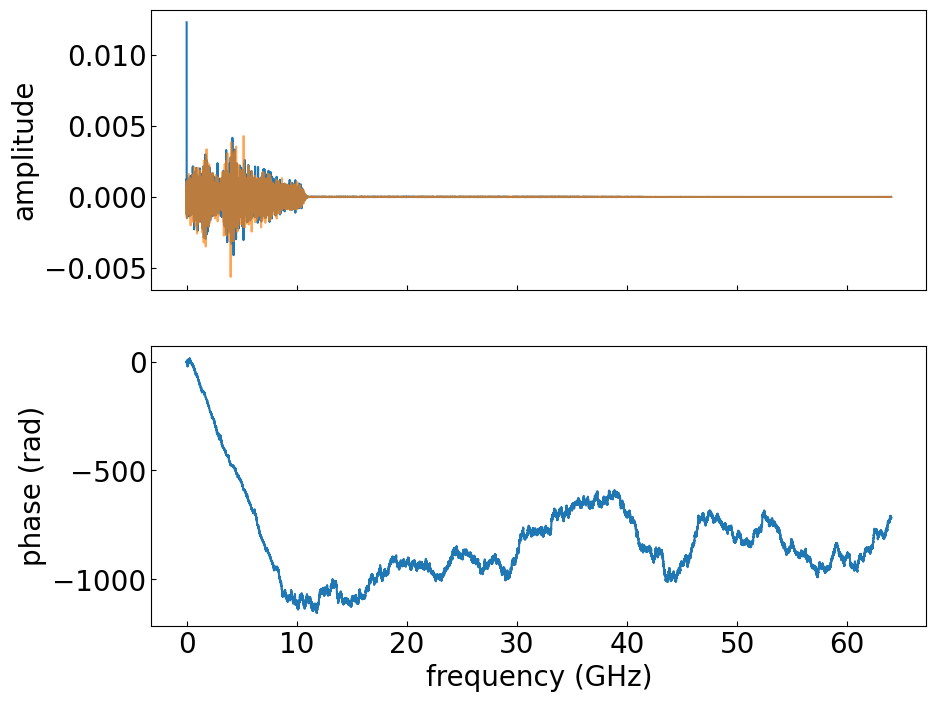

In [3]:
raw_N = len(raw_emp)
raw_dt = spstat.mode(np.diff(raw_time)).mode # should be regularly spaced. If it isn't, assume that it is mostly regularly spaced and use the modal average.
raw_FFT = np.fft.rfft(raw_emp, norm= "forward")
raw_PS = np.abs(raw_FFT)
raw_freqs = np.fft.rfftfreq(raw_N, raw_dt) # dt was in ns so freqs should be in GHz
raw_phase = np.unwrap(np.angle(raw_FFT))

fig, axs = plt.subplots(2,1, sharex= True)

axs[0].plot(raw_freqs, raw_FFT.real)
axs[0].plot(raw_freqs, raw_FFT.imag, alpha= 0.7)
axs[0].set(ylabel= "amplitude")

axs[1].plot(raw_freqs, raw_phase)
axs[1].set(ylabel= "phase (rad)", xlabel= "frequency (GHz)")

plt.show()

## INSPECTING THE CORRECTED DATA FILE

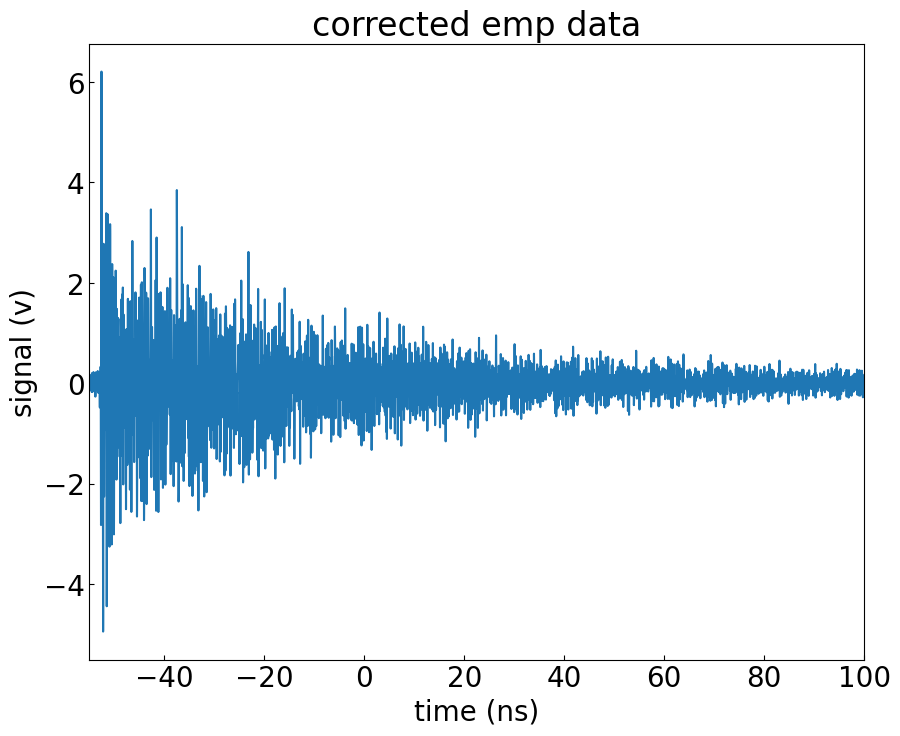

In [4]:
corrected_time, corrected_emp = np.genfromtxt(corrected_file, delimiter= ",", skip_header=1).T
trigger_index = next(n for n, t in enumerate(corrected_time) if trigger_time <= t)
corrected_time, corrected_emp, corrected_noise = corrected_time[trigger_index:], corrected_emp[trigger_index:], corrected_emp[:trigger_index] 

fig, axs = plt.subplots()

axs.plot(corrected_time, corrected_emp)
axs.set(xlim = (-55, 100), title= "corrected emp data", xlabel= "time (ns)", ylabel= "signal (v)")
plt.show()

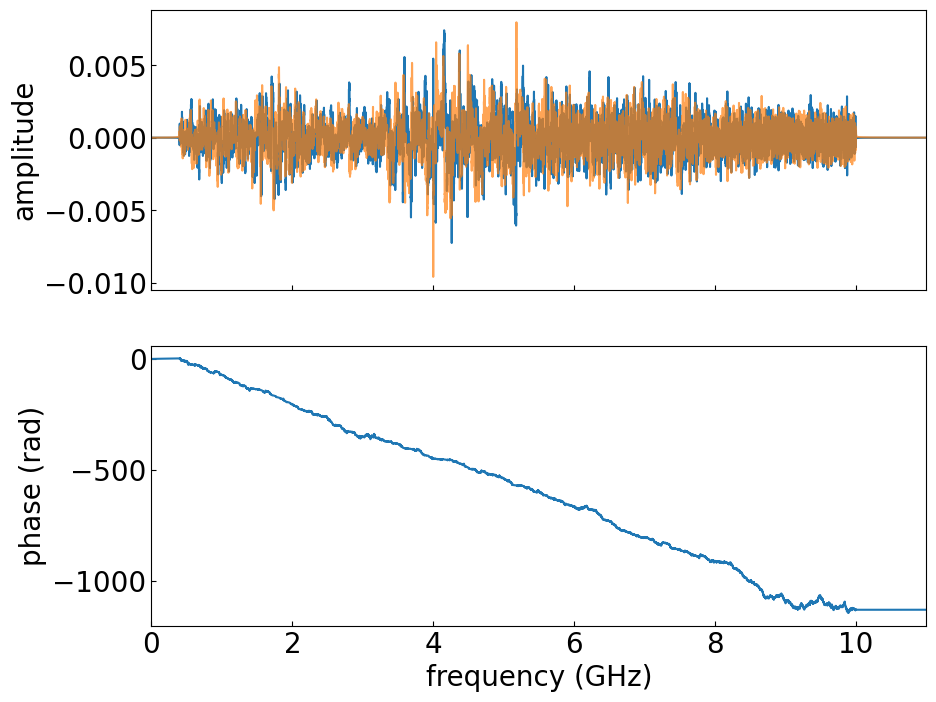

In [5]:
corrected_N = len(corrected_emp)
corrected_dt = spstat.mode(np.diff(corrected_time)).mode # should be regularly spaced. If it isn't, assume that it is mostly regularly spaced and use the modal average.
corrected_FFT = np.fft.rfft(corrected_emp, norm= "forward")
corrected_PS = np.abs(corrected_FFT)
corrected_freqs = np.fft.rfftfreq(corrected_N, corrected_dt) # dt was in ns so freqs should be in GHz
corrected_phase = np.unwrap(np.angle(corrected_FFT))

fig, axs = plt.subplots(2,1, sharex= True)

axs[0].plot(corrected_freqs, corrected_FFT.real)
axs[0].plot(corrected_freqs, corrected_FFT.imag, alpha= 0.7)
axs[0].set(ylabel= "amplitude")

axs[1].plot(corrected_freqs, corrected_phase)
axs[1].set(ylabel= "phase (rad)", xlabel= "frequency (GHz)", xlim= (0, 11))

plt.show()

## KRAMERS-KRONIG
Might not be suitable because it assumes that the function is causal - INCLUDING THE NOISE! It will attempt to make the noise zero in the latter half of the waveform.

In [6]:
corrected_kk_phase = empf.kramers_kronig(corrected_freqs, corrected_PS)

c:\Users\syf83691\OneDrive - Science and Technology Facilities Council\Documents\python\git_projects\EMP_phase_correction\emp_functions.py:52: RuntimeWarning: invalid value encountered in divide
  integrand= numerator/denominator


In [7]:
corrected_kk_FFT = corrected_PS *np.exp(1j*corrected_kk_phase) #apply phase
corrected_kk_emp = np.fft.irfft(corrected_kk_FFT, norm= "forward", n= corrected_N) #inverse fourier transform

C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


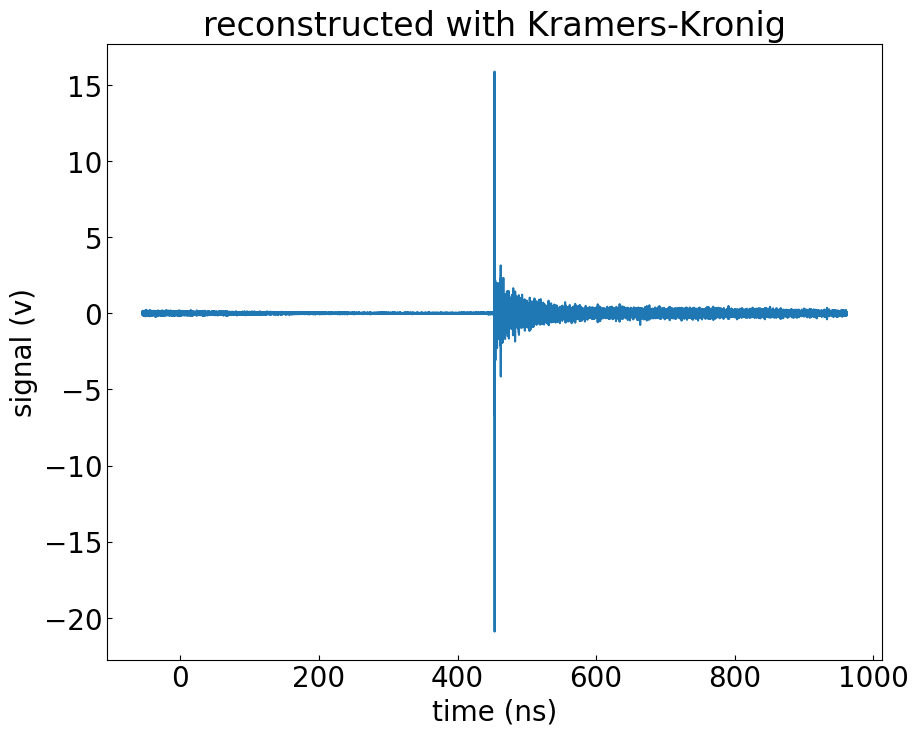

In [8]:
fig, axs = plt.subplots()

axs.plot(corrected_time, empf.recenter(corrected_kk_emp))
axs.set(xlabel= "time (ns)", ylabel= "signal (v)", title= "reconstructed with Kramers-Kronig")
plt.show()

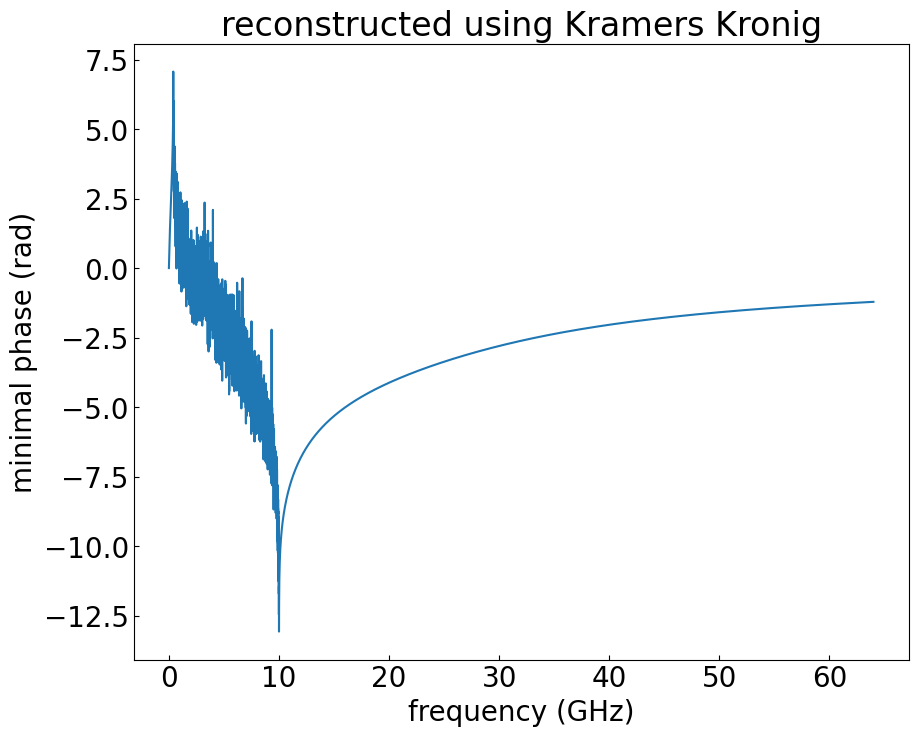

In [9]:
fig, axs = plt.subplots()

axs.plot(corrected_freqs, corrected_kk_phase)
axs.set(xlabel= "frequency (GHz)", ylabel= "minimal phase (rad)", title= "reconstructed using Kramers Kronig")
plt.show()

## GERCHBERG-SAXON
Might work better but I need to be careful as to which assumptions I use and how I apply them.
At the moment, it doesn't work because I am not making enough assumptions. The corrected signal already complies with all of the assumptions so gerchberg-saxon doesn't need to change it.

In [10]:
valid_range = [0.4, 10] #GHz

corrected_mask = np.logical_and(valid_range[0] <= corrected_freqs, corrected_freqs <= valid_range[1])
corrected_noise_level = np.max(np.abs(corrected_noise)) # Because emp is causal, this should all be noise.

In [11]:
corrected_gs_FFT = empf.gerchberg_saxon(corrected_PS, sensitivity_mask= corrected_mask, initial_guess= corrected_emp, noise_level= corrected_noise_level, iterations= 1000, gamma= 0.97)
corrected_gs_phase = np.unwrap(np.angle(corrected_gs_FFT))
corrected_gs_emp = np.fft.irfft(corrected_gs_FFT, norm= "forward", n= corrected_N)

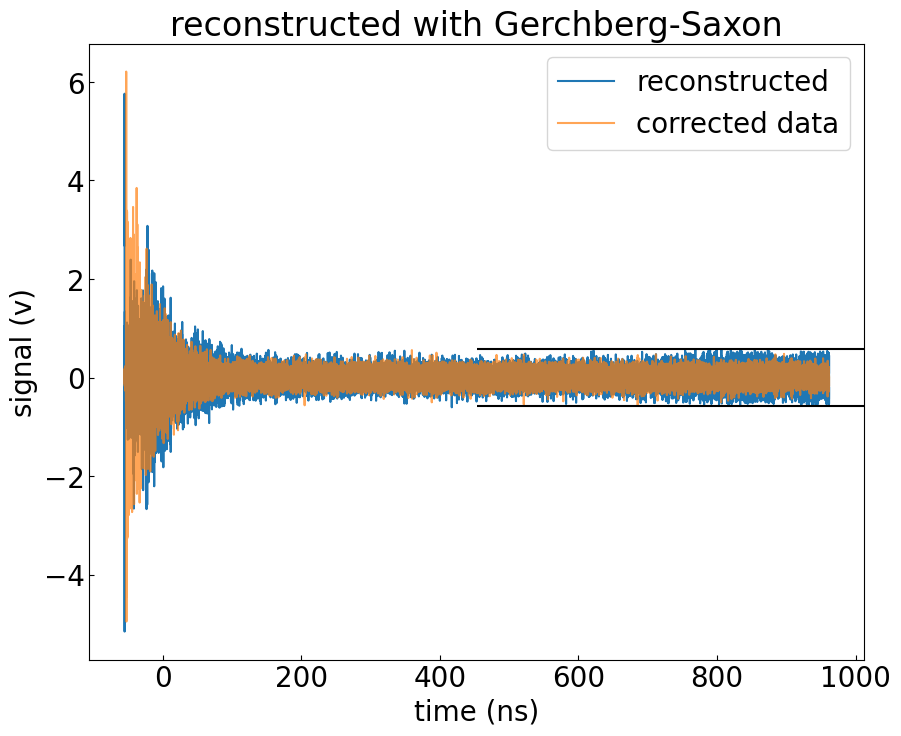

In [17]:
fig, axs = plt.subplots()

axs.plot(corrected_time, corrected_gs_emp, label= "reconstructed")
axs.plot(corrected_time, corrected_emp, alpha= 0.7, label= "corrected data")
axs.set(xlabel= "time (ns)", ylabel= "signal (v)", title= "reconstructed with Gerchberg-Saxon")
axs.hlines([-corrected_noise_level, corrected_noise_level], 0.5, 1, color= "k", transform= axs.get_yaxis_transform())

plt.legend()
plt.show()

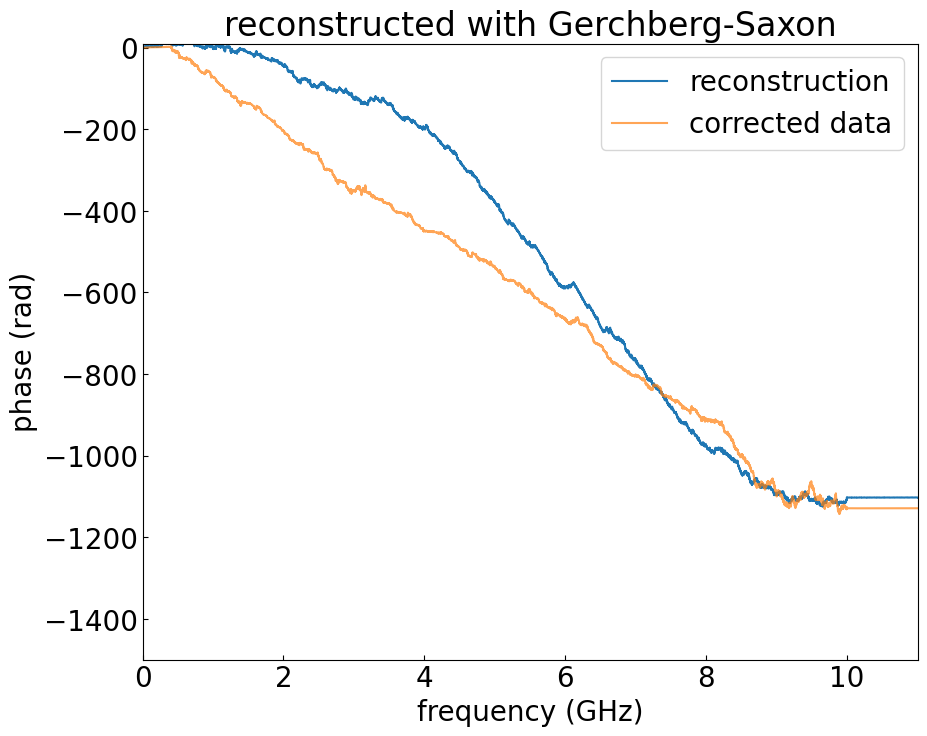

In [16]:
fig, axs = plt.subplots()

axs.plot(corrected_freqs, corrected_gs_phase, label= "reconstruction")
axs.plot(corrected_freqs, corrected_phase, alpha= 0.7, label= "corrected data")
axs.set(xlabel= "frequency (GHz)", ylabel= "phase (rad)", title= "reconstructed with Gerchberg-Saxon", xlim= (0, 11), ylim= (-1500, 10))

plt.legend()
plt.show()

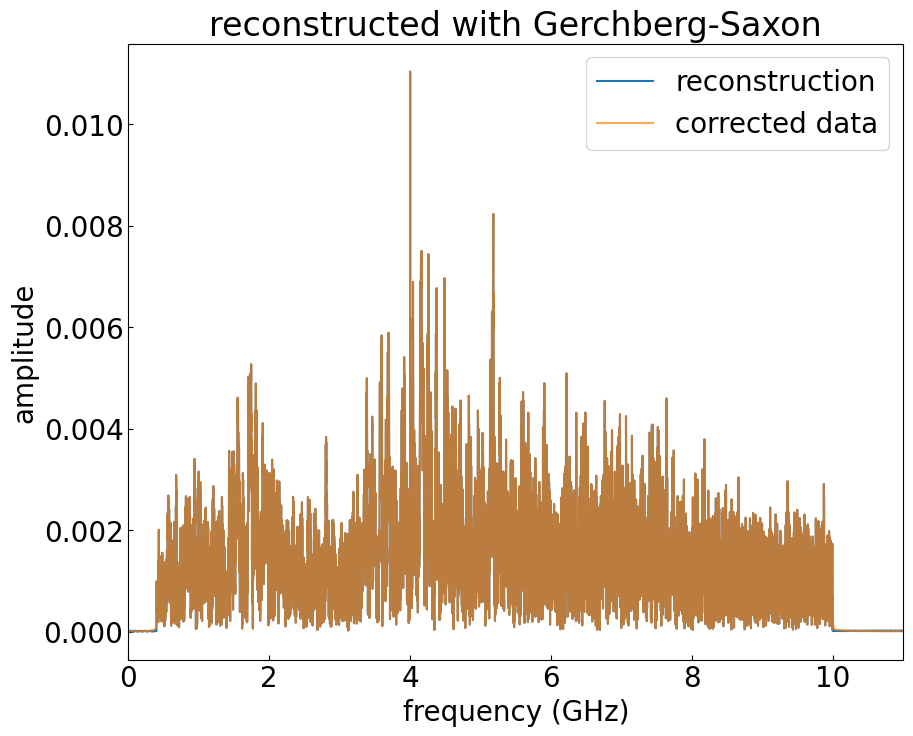

In [14]:
fig, axs = plt.subplots()

axs.plot(corrected_freqs, np.abs(corrected_gs_FFT), label= "reconstruction")
axs.plot(corrected_freqs, corrected_PS, alpha= 0.7, label= "corrected data")
axs.set(xlabel= "frequency (GHz)", ylabel= "amplitude", title= "reconstructed with Gerchberg-Saxon", xlim= (0, 11))

plt.legend()
plt.show()